In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
import shap
shap.initjs()

import graphviz
from sklearn.tree import export_graphviz
import pydot

In [2]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb
from sklearn.cluster import FeatureAgglomeration

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from scipy.stats import rankdata

In [3]:
from keras.layers import Input, Dense, Flatten, Concatenate, concatenate, Dropout, Bidirectional, LSTM
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop
from keras.utils import np_utils

/home/rania/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


this function is used to get the precision of the model @ top K

In [4]:
def score_topK(yv, ypred):
    print('Precision @')
    ttest = pd.DataFrame({'true':yv,'pred1':ypred})
    ttest['ranking'] = rankdata(ttest.pred1, 'min')
    ttest['ranking'] = ttest.ranking.max()-ttest.ranking+1
    for topK in [50,100,150,175]:
        ttest['pred'+str(topK)] = ttest.ranking <= topK
        print('TOP K %d ' % (topK))
        if ttest.shape[0]:
            cm = confusion_matrix(ttest.true, ttest['pred'+str(topK)])
            print('-- %.2f #Churners: %d #TT: %d #FT: %d' %
                   (precision_score(ttest.true, ttest['pred'+str(topK)]).round(2),
                    cm[1][1]+cm[0][1], cm[1][1], cm[0][1]))
            
    return ttest.loc[ttest.ranking<=175, 'pred1'].min()

data is loaded, forecast features are discarded as well as empty columns - all tables are joined into a wide matrix indexed by client id

In [6]:
path = '~/powerco/Files/'
dates_cols = ['date_activ','date_end','date_first_activ','date_modif_prod','date_renewal']
cat_cols = ['activity_new', 'channel_sales', 'has_gas', 'origin_up']
target_cols = ['churn']

training_data = pd.read_csv(path+'ml_case_training_data.csv', parse_dates=dates_cols).dropna(axis=1, how='all')
training_hist_data = pd.read_csv(path+'ml_case_training_hist_data.csv')
training_output = pd.read_csv(path+'ml_case_training_output.csv')
test_data = pd.read_csv(path+'ml_case_test_data.csv', parse_dates=dates_cols, usecols=training_data.columns)
test_hist_data = pd.read_csv(path+'ml_case_test_hist_data.csv')

In [7]:
prices = ['price_p1_fix','price_p1_var','price_p2_fix','price_p2_var','price_p3_fix','price_p3_var']
df_hist_data = training_hist_data.append(test_hist_data).pivot_table(index='id', columns='price_date', values=prices)
df_hist_data.columns = ['_'.join(col).strip().replace('-','') for col in df_hist_data.columns.values]
ts_cols = df_hist_data.columns.tolist()

In [8]:
#ts_cols

In [9]:
all_cols = training_data.columns.tolist()
num_cols = list(set(all_cols)-set(dates_cols)-set(ts_cols)-set(target_cols)-set(cat_cols)-set(['id']))
num_cols = [c for c in num_cols if 'forecast' not in c]
features = num_cols + cat_cols + dates_cols + ts_cols
len(features)

91

# monthly prices evolution

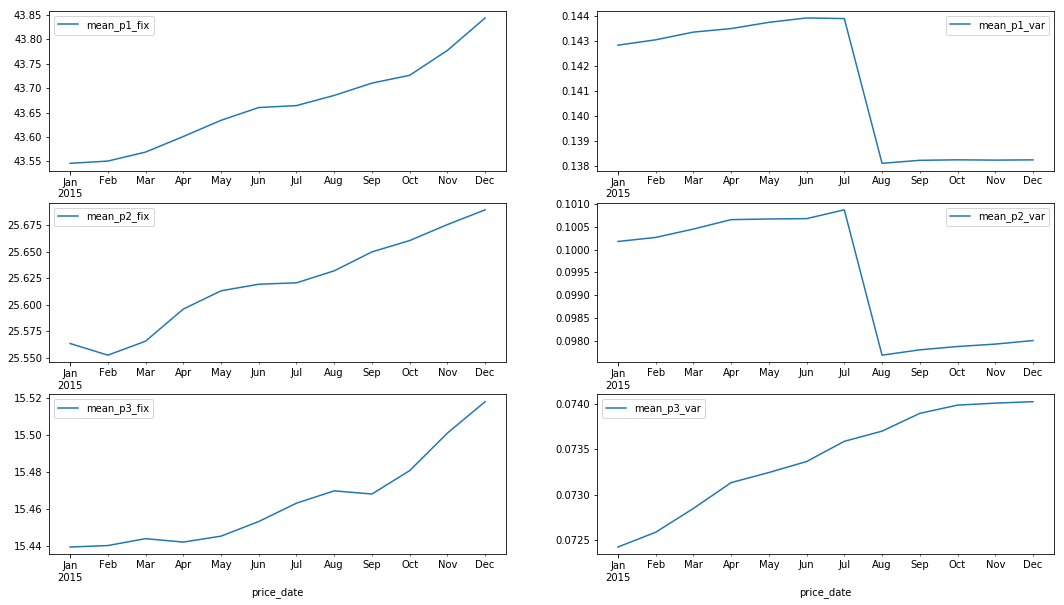

In [10]:
df = training_hist_data.append(test_hist_data).replace(0, np.nan)
df.price_date = pd.to_datetime(df.price_date)

fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(10);fig.set_figwidth(18)

for i,c in enumerate(prices):
    df.groupby('price_date')[c].mean().plot(ax=axes[i//2,i%2])
    axes[i//2,i%2].legend(['mean_'+c[6:]])

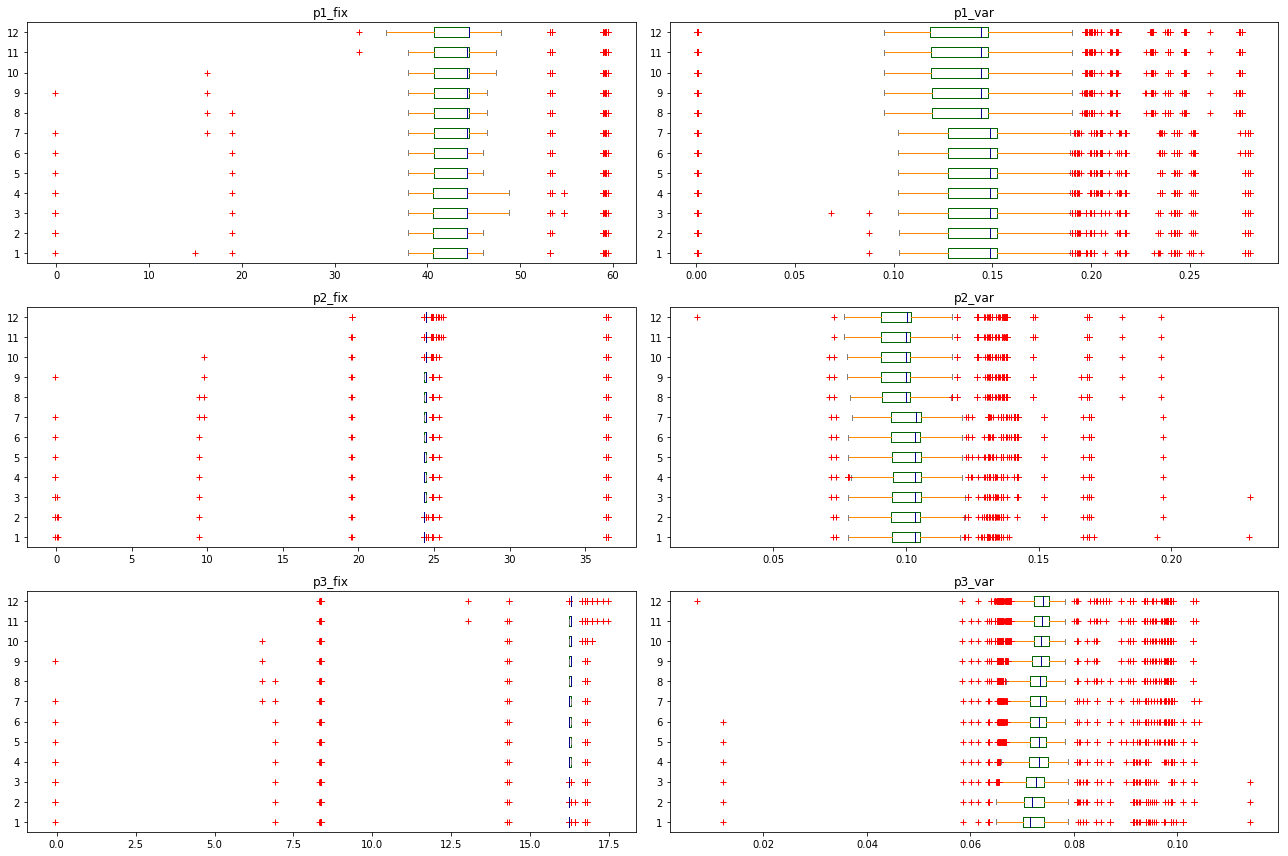

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(12);fig.set_figwidth(18)

for i,c in enumerate(prices):
    tmp = df[['id','price_date',c]]
    df.pivot(index='id', columns='price_date', 
             values=c).rename(lambda x: x.month, axis='columns').plot.box(ax=axes[i//2,i%2],
             color=dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray'), sym='r+',
             vert=False)
    axes[i//2,i%2].set_title(c[6:])
plt.tight_layout()

# cleaning and basic feature engineering

In [12]:
def get_df(scale=False, fillna=False):
    
    global training_data, training_output, test_data, df_hist_data, cat_cols, dates_cols, ts_cols, num_cols
    df = training_data.merge(training_output).append(test_data).set_index('id').join(df_hist_data)
    means = {}
    stds = {}
    
    for c in df.columns:
        if c in cat_cols:
            print('cat %s' % c)
            df[c] = df[c].astype('category').cat.codes
        elif c in dates_cols:
            print('date % s' % c)
            df[c] = pd.datetime(2016,1,1)-df[c]
            df.loc[df[c].notnull(), c] = df.loc[df[c].notnull(), c].dt.days.astype(int)
        if scale and c in dates_cols+ts_cols+num_cols:
            means[c]=df.loc[df.churn.notnull(), c].mean()
            stds[c]=df.loc[df.churn.notnull(), c].std()
            df[c]=((df[c]-means[c])/stds[c])
        if fillna and c in dates_cols+ts_cols+num_cols:
            df[c].fillna(df.loc[df.churn.notnull(), c].mean(), inplace=True)
            
    return df

df=get_df()

cat activity_new
cat channel_sales
date date_activ
date date_end
date date_first_activ
date date_modif_prod
date date_renewal
cat has_gas
cat origin_up


Viewing churning clients relative to some features

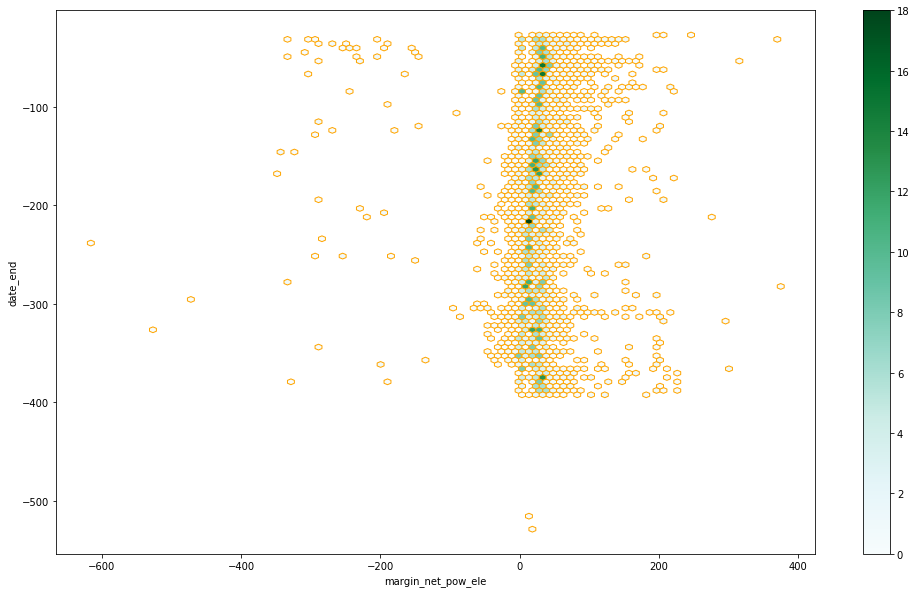

In [13]:
df.loc[(df.date_end<365)&(df.date_end>-365*2),
       ['margin_net_pow_ele','date_end','churn']].dropna().astype(float).plot.hexbin(
            x='margin_net_pow_ele', y='date_end', C='churn', reduce_C_function=np.sum, 
            gridsize=100, sharex=False, figsize=(17,10), color='orange')

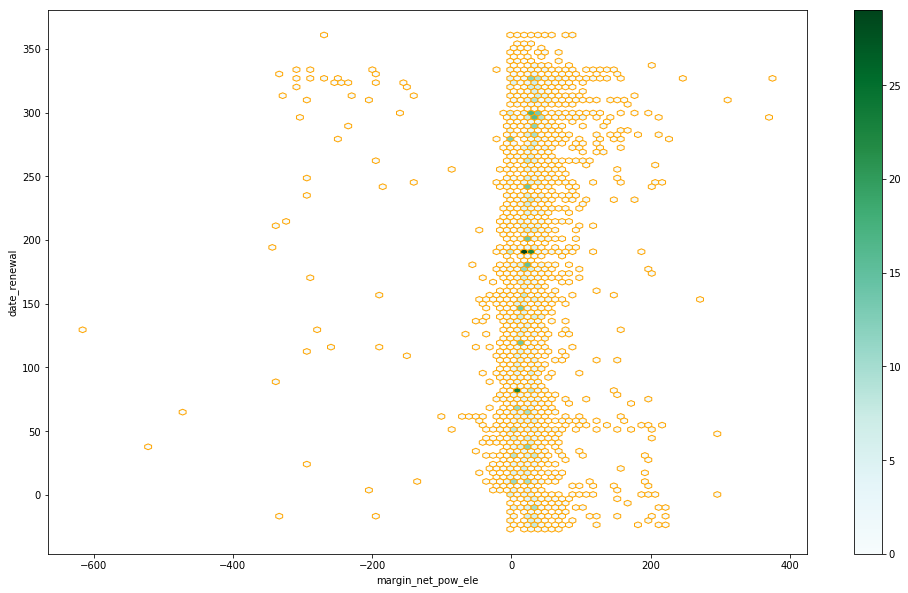

In [14]:
df.loc[(df.date_renewal<365)&(df.date_renewal>-365*2),
       ['margin_net_pow_ele','date_renewal','churn']].dropna().astype(float).plot.hexbin(
            x='margin_net_pow_ele', y='date_renewal', C='churn', reduce_C_function=np.sum, 
            gridsize=100, sharex=False, figsize=(17,10), color='orange')

# decision Tree

In [15]:
df=get_df(scale=False, fillna=True)

X = df.loc[df.churn.notnull(), features]
y = df.loc[df.churn.notnull(), 'churn']

Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)

cat activity_new
cat channel_sales
date date_activ
date date_end
date date_first_activ
date date_modif_prod
date date_renewal
cat has_gas
cat origin_up


In [16]:
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(Xt, yt)
y_pred = dt.predict_proba(Xv)
score_topK(yv, y_pred[:,1])

Precision @
TOP K 50 
-- 0.29 #Churners: 31 #TT: 9 #FT: 22
TOP K 100 
-- 0.23 #Churners: 82 #TT: 19 #FT: 63
TOP K 150 
-- 0.23 #Churners: 82 #TT: 19 #FT: 63
TOP K 175 
-- 0.23 #Churners: 82 #TT: 19 #FT: 63


0.2315270935960591

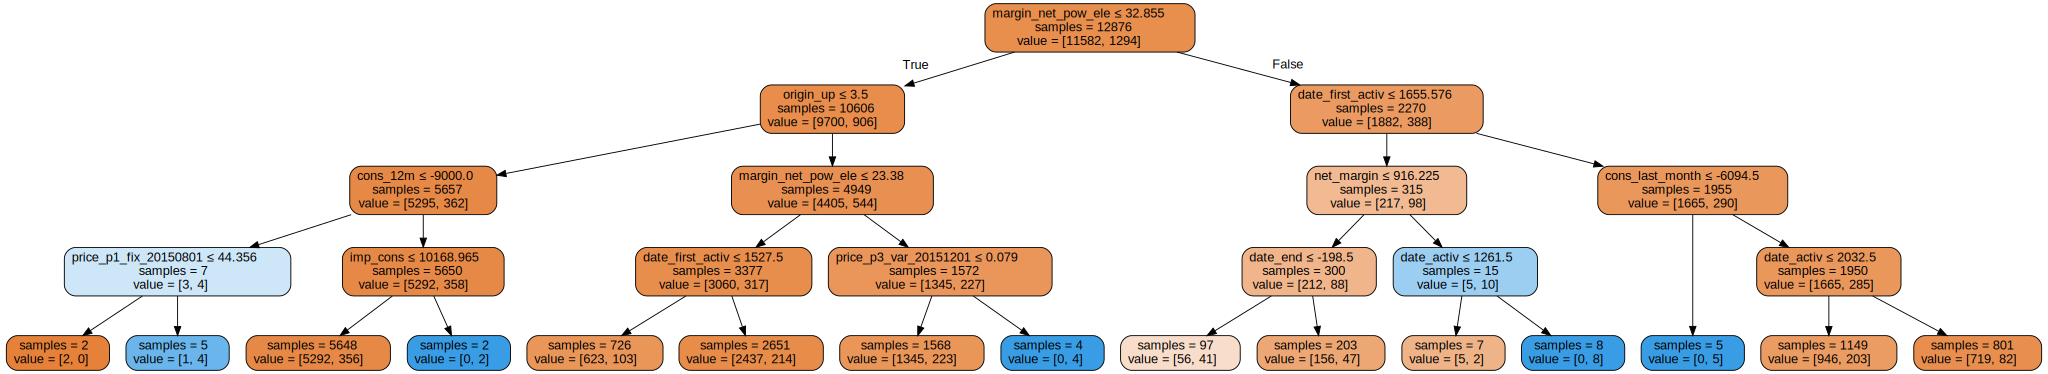

In [17]:
dot_data = export_graphviz(dt, out_file='dt', feature_names=features, filled=True, rounded=True, 
                           special_characters=True, impurity=False, rotate=False, leaves_parallel=True)
graph = graphviz.Source(dot_data)
graph.from_file("dt")

In [18]:
(graph,) = pydot.graph_from_dot_file('dt')
graph.write_png('dt.png')

In [19]:
df=get_df(scale=True, fillna=True)

X = df.loc[df.churn.notnull(), [c for c in features if c not in cat_cols]]
y = df.loc[df.churn.notnull(), 'churn']

Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)

pipe = Pipeline(steps=[('fagg', FeatureAgglomeration()), ('logistic', linear_model.LogisticRegression())])
estimator = GridSearchCV(pipe,
                         dict(fagg__n_clusters=[2, 10, 20, 30],
                              logistic__C=np.logspace(-4, 4, 5)))
estimator.fit(Xt, yt)

cat activity_new
cat channel_sales
date date_activ
date date_end
date date_first_activ
date date_modif_prod
date date_renewal
cat has_gas
cat origin_up


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('fagg', FeatureAgglomeration(affinity='euclidean', compute_full_tree='auto',
           connectivity=None, linkage='ward', memory=None, n_clusters=2,
           pooling_func=<function mean at 0x7f01541d2d08>)), ('logistic', LogisticRegression(C=1.0, class...y='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'fagg__n_clusters': [2, 10, 20, 30], 'logistic__C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [20]:
score_topK(yv, estimator.predict_proba(Xv)[:,1])

Precision @
TOP K 50 
-- 0.18 #Churners: 50 #TT: 9 #FT: 41
TOP K 100 
-- 0.21 #Churners: 100 #TT: 21 #FT: 79
TOP K 150 
-- 0.19 #Churners: 150 #TT: 28 #FT: 122
TOP K 175 
-- 0.19 #Churners: 175 #TT: 33 #FT: 142


0.1654822344931485

In [21]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('fagg', FeatureAgglomeration(affinity='euclidean', compute_full_tree='auto',
           connectivity=None, linkage='ward', memory=None, n_clusters=10,
           pooling_func=<function mean at 0x7f01541d2d08>)), ('logistic', LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

# KERAS for fun

In [22]:
df=get_df(scale=True, fillna=True)

X = df.loc[df.churn.notnull(), features]
y = df.loc[df.churn.notnull(), 'churn']

Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)

cat activity_new
cat channel_sales
date date_activ
date date_end
date date_first_activ
date date_modif_prod
date date_renewal
cat has_gas
cat origin_up


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20120 entries, 48ada52261e7cf58715202705a0451c9 to 9d04b44f8d8be096420da85198b5d1e3
Columns: 103 entries, activity_new to price_p3_var_20151201
dtypes: float64(98), int16(1), int64(1), int8(3)
memory usage: 16.1+ MB


In [24]:
bcg_input_cat = [Input(shape=(1,)) for c in cat_cols]
bcg_input_num = Input(shape=(len(num_cols+dates_cols),))
bcg_input_ts = Input(shape=(12,6))

bcg_output_cat = [Flatten()(Dropout(0.1)(Embedding(df[c].max()+2, 2)(x))) for c,x in zip(cat_cols, bcg_input_cat)]
bcg_output_num = Dropout(0.1)(Dense(100, activation='selu')(bcg_input_num))
bcg_output_ts = Bidirectional(LSTM(25, return_sequences=True, dropout= 0.1, recurrent_dropout= 0.1),
                              merge_mode='ave')(bcg_input_ts)
bcg_output_ts = LSTM(26, return_sequences=False, dropout= 0.1, recurrent_dropout= 0.1)(bcg_output_ts)

bcg_output = concatenate(bcg_output_cat + [bcg_output_num, bcg_output_ts])
bcg_output = Dense(100, activation='selu')(bcg_output)
bcg_output = Dropout(0.5)(bcg_output)
bcg_output = Dense(100, activation='selu')(bcg_output)
bcg_output = Dropout(0.1)(bcg_output)
bcg_output = Dense(2, activation='softmax')(bcg_output)

In [25]:
bcg_model = Model(bcg_input_cat+[bcg_input_num, bcg_input_ts], bcg_output)

In [26]:
bcg_model.compile(optimizer=RMSprop(lr=0.001, rho=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
bcg_model.fit(
    [Xt[c].as_matrix()+1 for c in cat_cols]+[Xt[num_cols+dates_cols].values,
                                           Xt[ts_cols].values.reshape(-1,6,12).swapaxes(2,1)],
     np_utils.to_categorical(yt, 2),
     epochs=20,
     batch_size=100,
     shuffle=True,
     validation_data=([Xv[c].as_matrix()+1 for c in cat_cols]+[Xv[num_cols+dates_cols].values,
                                                             Xv[ts_cols].values.reshape(-1,6,12).swapaxes(2,1)], 
                      np_utils.to_categorical(yv, 2))
)

Train on 12876 samples, validate on 3220 samples
Epoch 1/20
12876/12876 [==============================] - 9s 672us/step - loss: 0.3773 - acc: 0.8814 - val_loss: 0.3072 - val_acc: 0.9065
Epoch 2/20
12876/12876 [==============================] - 7s 512us/step - loss: 0.3453 - acc: 0.8945 - val_loss: 0.3101 - val_acc: 0.9065
Epoch 3/20
12876/12876 [==============================] - 7s 517us/step - loss: 0.3490 - acc: 0.8945 - val_loss: 0.3135 - val_acc: 0.9062
Epoch 4/20
12876/12876 [==============================] - 7s 515us/step - loss: 0.3406 - acc: 0.8952 - val_loss: 0.3379 - val_acc: 0.9000
Epoch 5/20
12876/12876 [==============================] - 7s 513us/step - loss: 0.3418 - acc: 0.8962 - val_loss: 0.2987 - val_acc: 0.9062
Epoch 6/20
12876/12876 [==============================] - 7s 513us/step - loss: 0.3401 - acc: 0.8962 - val_loss: 0.3100 - val_acc: 0.9062
Epoch 7/20
12876/12876 [==============================] - 7s 511us/step - loss: 0.3336 - acc: 0.8975 - val_loss: 0.2996 - v

In [28]:
score_topK(yv,
           bcg_model.predict([Xv[c].as_matrix()+1 for c in cat_cols]+[Xv[num_cols+dates_cols].values,
                                    Xv[ts_cols].values.reshape(-1,6,12).swapaxes(2,1)])[:,1])

Precision @
TOP K 50 
-- 0.00 #Churners: 50 #TT: 0 #FT: 50
TOP K 100 
-- 0.04 #Churners: 100 #TT: 4 #FT: 96
TOP K 150 
-- 0.07 #Churners: 150 #TT: 10 #FT: 140
TOP K 175 
-- 0.09 #Churners: 175 #TT: 16 #FT: 159


0.041237872

# XGB

In [29]:
df=get_df(scale=False, fillna=True)

X = df.loc[df.churn.notnull(), features]
y = df.loc[df.churn.notnull(), 'churn']

Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)
dt = xgb.DMatrix(Xt.as_matrix(), label=yt.as_matrix())
dv = xgb.DMatrix(Xv.as_matrix(), label=yv.as_matrix())

cat activity_new
cat channel_sales
date date_activ
date date_end
date date_first_activ
date date_modif_prod
date date_renewal
cat has_gas
cat origin_up


### starter

In [30]:
params = {
    "eta": 0.2,
    "max_depth": 4,
    "objective": "binary:logistic",
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model0 = xgb.train(params, dt, 100, [(dt, "train"),(dv, "valid")], verbose_eval=100)
score_topK(yv, model0.predict(dv))

[0]	train-logloss:0.319065	valid-logloss:0.304828
[99]	train-logloss:0.224409	valid-logloss:0.269854
Precision @
TOP K 50 
-- 0.70 #Churners: 50 #TT: 35 #FT: 15
TOP K 100 
-- 0.58 #Churners: 100 #TT: 58 #FT: 42
TOP K 150 
-- 0.49 #Churners: 150 #TT: 73 #FT: 77
TOP K 175 
-- 0.44 #Churners: 175 #TT: 77 #FT: 98


0.24651071

In [31]:
shap_values = model0.predict(dv, pred_contribs=True)

In [32]:
shap.visualize(shap_values[0,:], feature_names=Xv.columns, data=Xv.iloc[0,:])

/home/rania/anaconda3/lib/python3.6/site-packages/shap/plots.py:471: UserWarning: the visualize() function has been renamed to 'force_plot' for consistency
  warnings.warn("the visualize() function has been renamed to 'force_plot' for consistency")
/home/rania/anaconda3/lib/python3.6/site-packages/shap/plots.py:475: UserWarning: the 'data' parameter has been renamed to 'features' for consistency
  warnings.warn("the 'data' parameter has been renamed to 'features' for consistency")


In [33]:
shap.visualize(shap_values[:100,:], feature_names=Xv.columns, data=Xv.values[:100,:])

/home/rania/anaconda3/lib/python3.6/site-packages/shap/plots.py:471: UserWarning: the visualize() function has been renamed to 'force_plot' for consistency
  warnings.warn("the visualize() function has been renamed to 'force_plot' for consistency")
/home/rania/anaconda3/lib/python3.6/site-packages/shap/plots.py:475: UserWarning: the 'data' parameter has been renamed to 'features' for consistency
  warnings.warn("the 'data' parameter has been renamed to 'features' for consistency")


[<iml.explanations.AdditiveExplanation at 0x7f00fc6029b0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc602208>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc602780>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc602c88>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc602cc0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6029e8>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc602fd0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc602c18>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc602dd8>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6020b8>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6021d0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc734e48>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc734cc0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc7341d0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6d3e80>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6d30b8>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6d3198>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6deb70>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6de160>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6de588>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6deac8>,
 <iml.explanations.AdditiveExplanation at 0x7f00fdb1d978>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6e9828>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6e9e48>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6e9d30>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6026a0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc602588>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc602358>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc602470>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc778710>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc778630>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc778550>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc778470>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc778390>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc7782b0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc7781d0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc7780f0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc7789b0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc778f60>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc778e80>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc778da0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc778cc0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc778be0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc7789e8>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc778898>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc7787f0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6c9588>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6c9da0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6c9e10>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc6c9fd0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc72b320>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc72bef0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc72be10>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc72bd30>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc72bc50>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc72bb70>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc72ba90>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc72b9b0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc72b8d0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc72b7f0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc72b710>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc72b4e0>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc72b518>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc72b2e8>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc72b208>,
 <iml.explanations.AdditiveExplanation at 0x7f00fc72b128>,
 <iml.explanations.AdditiveExplanation at 0x7f0101a0c860>,
 <iml.explanations.AdditiveExplanation at 0x7f0

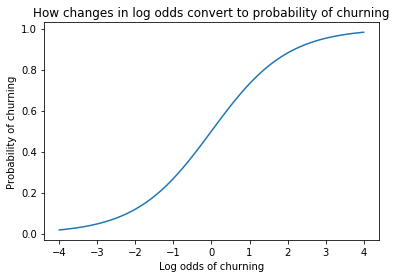

In [34]:
xs = np.linspace(-4,4,100)
plt.xlabel("Log odds of churning")
plt.ylabel("Probability of churning")
plt.title("How changes in log odds convert to probability of churning")
plt.plot(xs, 1/(1+np.exp(-xs)))
plt.show()

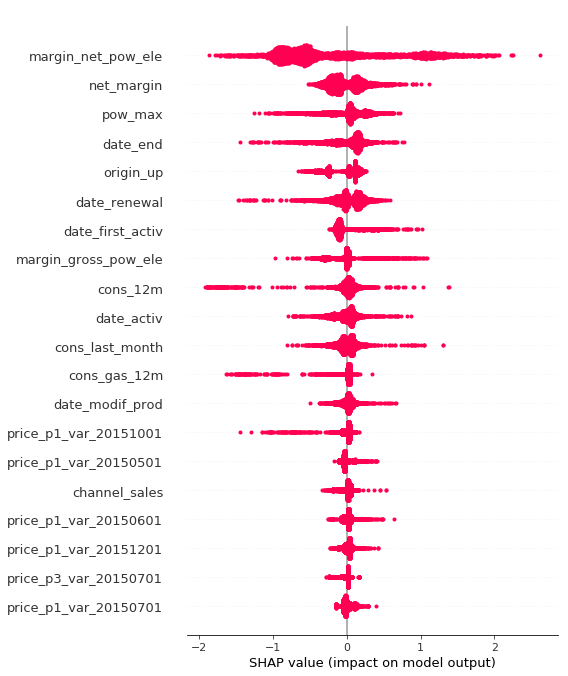

In [35]:
shap.summary_plot(shap_values, Xv.columns, max_display=20)

/home/rania/anaconda3/lib/python3.6/site-packages/shap/plots.py:663: UserWarning: shap.plot is deprecated in favor of shap.dependence_plot
  warnings.warn("shap.plot is deprecated in favor of shap.dependence_plot")


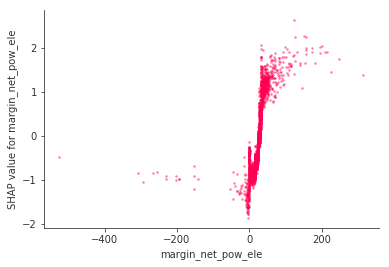

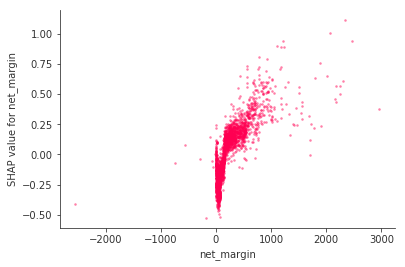

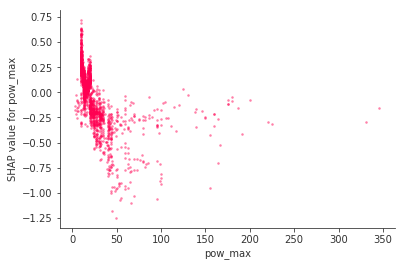

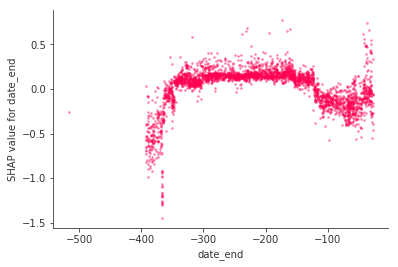

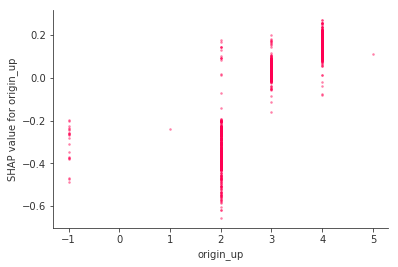

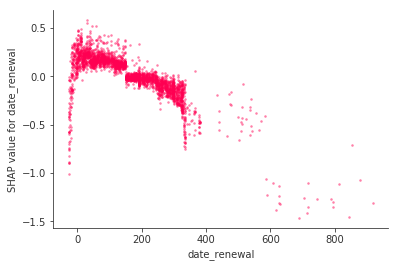

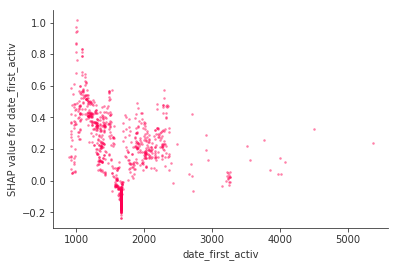

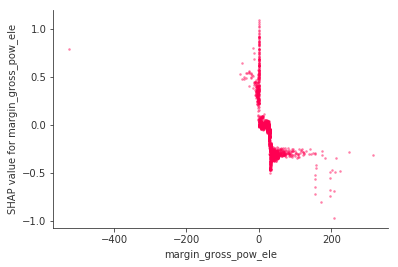

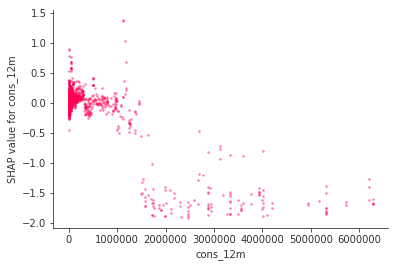

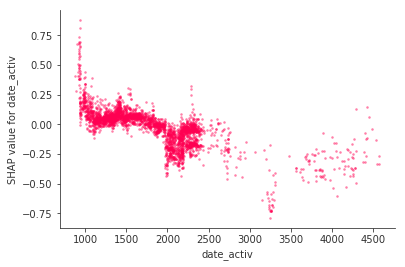

In [36]:
top_inds = np.argsort(-np.sum(np.abs(shap_values[:,:len(features)]), 0))
for i in range(10):
    shap.plot(Xv.iloc[:,top_inds[i]], shap_values[:,top_inds[i]], Xv.columns[top_inds[i]], alpha=0.5)

In [37]:
top_inds

array([ 4,  6,  2, 15, 13, 18, 16,  9,  0, 14,  7,  1, 17, 40, 35, 11, 36,
       42, 85, 37,  8, 38, 55, 10, 65, 77, 31, 81, 62, 78, 41, 30, 21, 43,
       67, 33, 84, 87, 34, 39, 66, 79, 59, 12, 32, 56, 54, 57, 88, 80, 47,
        5, 82, 64, 90, 76, 63, 25, 71, 89, 61, 27, 60, 73, 22, 58,  3, 20,
       28, 83, 23, 24, 19, 26, 86, 52, 72, 74, 53, 70, 69, 68, 29, 44, 46,
       48, 49, 50, 51, 75, 45])

/home/rania/anaconda3/lib/python3.6/site-packages/shap/plots.py:620: UserWarning: shap.interaction_plot is deprecated in favor of shap.dependence_plot
  warnings.warn("shap.interaction_plot is deprecated in favor of shap.dependence_plot")


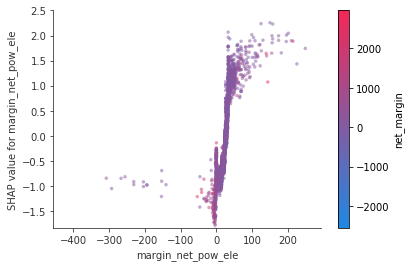

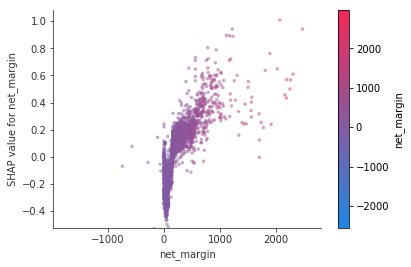

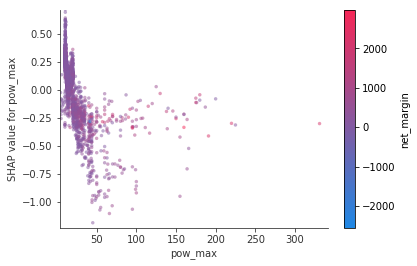

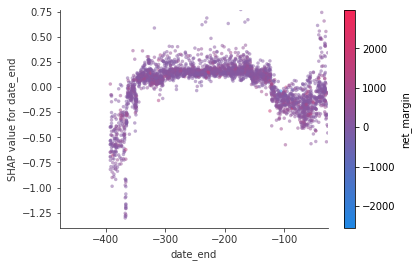

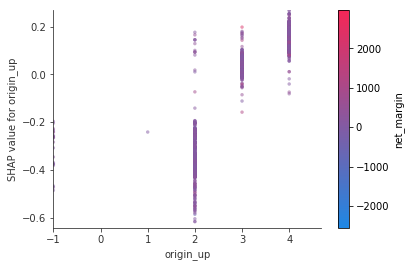

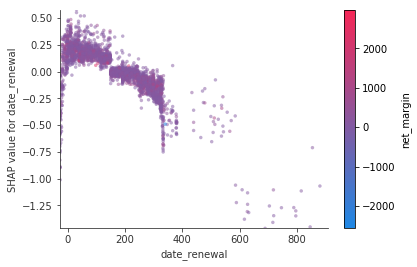

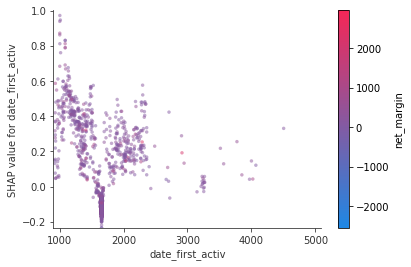

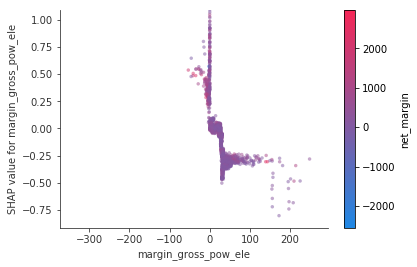

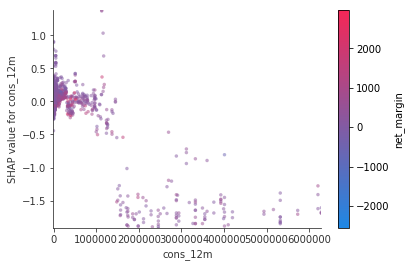

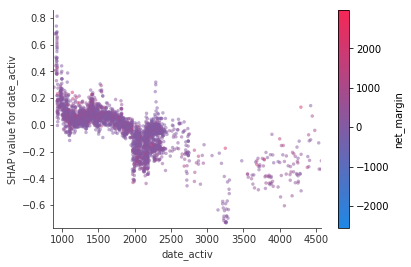

In [38]:
for i in range(10):
    plt.xlim(np.percentile(Xv.iloc[:,top_inds[i]], 0.01), np.percentile(Xv.iloc[:,top_inds[i]], 99.99))
    plt.ylim(np.percentile(shap_values[:,top_inds[i]], 0.01), np.percentile(shap_values[:,top_inds[i]], 99.99))
    shap.interaction_plot(top_inds[i], Xv, shap_values, alpha=.5, interaction_index=6)

### Train a model on just one feature to see marginal association

In [39]:
ind = np.where(Xv.columns == features[top_inds[0]])[0][0]
Xt_min = Xt.iloc[:,ind:ind+1]
Xv_min = Xv.iloc[:,ind:ind+1]
dt_min = xgb.DMatrix(Xt_min,label=yt.as_matrix())
dv_min = xgb.DMatrix(Xv_min,label=yv.as_matrix())
params = {
    "eta": 0.1,
    "max_depth": 4,
    "objective": "binary:logistic",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model_min = xgb.train(params, dt_min, 100, [(dt_min, "train"),(dv_min, "valid")], verbose_eval=10)

[0]	train-logloss:0.324127	valid-logloss:0.309293
[10]	train-logloss:0.315311	valid-logloss:0.302996
[20]	train-logloss:0.312775	valid-logloss:0.302362
[30]	train-logloss:0.311043	valid-logloss:0.302314
[40]	train-logloss:0.309892	valid-logloss:0.302451
[50]	train-logloss:0.30865	valid-logloss:0.302769
[60]	train-logloss:0.30746	valid-logloss:0.302913
[70]	train-logloss:0.306524	valid-logloss:0.303122
[80]	train-logloss:0.305667	valid-logloss:0.303319
[90]	train-logloss:0.304672	valid-logloss:0.303326
[99]	train-logloss:0.304025	valid-logloss:0.303586


In [40]:
shap_values_min = model_min.predict(dv_min, pred_contribs=True)

/home/rania/anaconda3/lib/python3.6/site-packages/shap/plots.py:663: UserWarning: shap.plot is deprecated in favor of shap.dependence_plot
  warnings.warn("shap.plot is deprecated in favor of shap.dependence_plot")


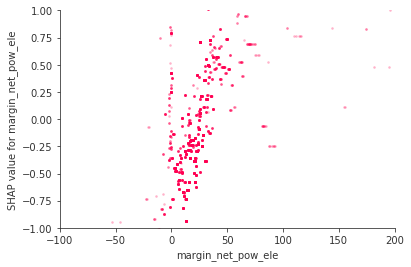

In [41]:
plt.xlim(-100,200)
plt.ylim(-1,1) 
shap.plot(Xv_min.iloc[:,0], shap_values_min[:,0], Xv_min.columns[0], alpha=0.3)

### Train a model with only two leaves per tree and hence no interaction terms between features

In [42]:
params = {
    "max_bin": 512,
    "eta": 0.1,
    "num_leaves": 2,
    "objective": "binary:logistic",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss",
    "min_data": 100,
    "boost_from_average": True,
    "verbose": -1,
}

model_ind = xgb.train(params, dt, 200, [(dt, "train"),(dv, "valid")], verbose_eval=100)

[0]	train-logloss:0.318618	valid-logloss:0.305987
[100]	train-logloss:0.203992	valid-logloss:0.267044
[199]	train-logloss:0.157593	valid-logloss:0.267312


In [43]:
shap_values_ind = model_ind.predict(dv, pred_contribs=True)

In [44]:
np.argsort(-np.sum(np.abs(shap_values_ind[:,:len(features)]), 0))

array([ 4,  9,  2, 18, 13,  0, 15,  6, 16,  7, 14,  1, 17, 35, 41,  8, 11,
       36, 40, 55, 34, 42, 37, 10, 31, 38, 63, 77, 65, 33, 32, 79, 81, 60,
       61, 66, 39, 21, 85, 84, 89, 30, 59, 62, 82, 86, 58, 67,  5, 87, 56,
       88, 90, 64, 57, 29, 28, 12, 47, 83, 23, 26, 24, 80, 52, 25, 43,  3,
       78, 50, 73, 19, 48, 76, 75, 53, 72, 44, 71, 54, 20, 74, 69, 46, 51,
       70, 68, 49, 45, 27, 22])

/home/rania/anaconda3/lib/python3.6/site-packages/shap/plots.py:663: UserWarning: shap.plot is deprecated in favor of shap.dependence_plot
  warnings.warn("shap.plot is deprecated in favor of shap.dependence_plot")


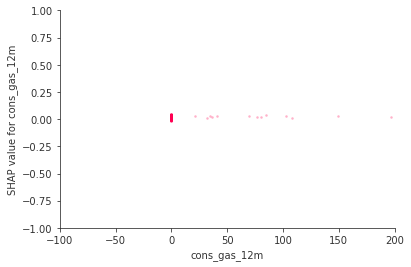

In [45]:
plt.xlim(-100,200)
plt.ylim(-1,1) 
shap.plot(Xv.iloc[:,1], shap_values[:,1], Xv.columns[1], alpha=0.3)

/home/rania/anaconda3/lib/python3.6/site-packages/shap/plots.py:663: UserWarning: shap.plot is deprecated in favor of shap.dependence_plot
  warnings.warn("shap.plot is deprecated in favor of shap.dependence_plot")


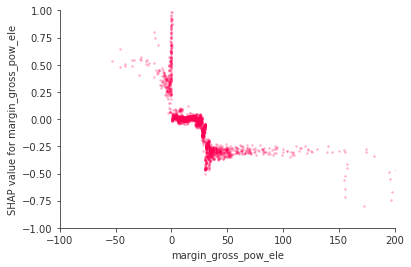

In [46]:
plt.xlim(-100,200)
plt.ylim(-1,1) 
shap.plot(Xv.iloc[:,9], shap_values[:,9], Xv.columns[9], alpha=0.3)

/home/rania/anaconda3/lib/python3.6/site-packages/shap/plots.py:663: UserWarning: shap.plot is deprecated in favor of shap.dependence_plot
  warnings.warn("shap.plot is deprecated in favor of shap.dependence_plot")


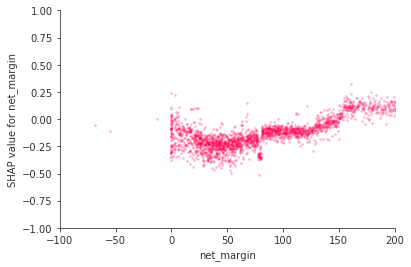

In [47]:
plt.xlim(-100,200)
plt.ylim(-1,1) 
shap.plot(Xv.iloc[:,6], shap_values[:,6], Xv.columns[6], alpha=0.3)

# Submission model

In [48]:
params = {
    "eta": 0.01,
    "max_depth": 6,
    "objective": "binary:logistic",
    "silent": 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model = xgb.train(params, dt, 1800, [(dt, "train"),(dv, "valid")], verbose_eval=100)

[0]	train-logloss:0.325503	valid-logloss:0.310455
[100]	train-logloss:0.283179	valid-logloss:0.286908
[200]	train-logloss:0.265354	valid-logloss:0.279274
[300]	train-logloss:0.253715	valid-logloss:0.275231
[400]	train-logloss:0.243733	valid-logloss:0.272482
[500]	train-logloss:0.233833	valid-logloss:0.270434
[600]	train-logloss:0.224758	valid-logloss:0.268964
[700]	train-logloss:0.216314	valid-logloss:0.267527
[800]	train-logloss:0.207823	valid-logloss:0.266143
[900]	train-logloss:0.200501	valid-logloss:0.265694
[1000]	train-logloss:0.193609	valid-logloss:0.265007
[1100]	train-logloss:0.18714	valid-logloss:0.264445
[1200]	train-logloss:0.181008	valid-logloss:0.263787
[1300]	train-logloss:0.174938	valid-logloss:0.262947
[1400]	train-logloss:0.169614	valid-logloss:0.262549
[1500]	train-logloss:0.163972	valid-logloss:0.262424
[1600]	train-logloss:0.158443	valid-logloss:0.262464
[1700]	train-logloss:0.153083	valid-logloss:0.262509
[1799]	train-logloss:0.148388	valid-logloss:0.262352


In [49]:
model.predict(xgb.DMatrix(X.as_matrix()))

array([0.02404307, 0.69191873, 0.05273557, ..., 0.27507526, 0.04733336,
       0.06221445], dtype=float32)

### Submission is made in a way to reach 50% precision

In [50]:
score_topK(yv, model.predict(dv))

Precision @
TOP K 50 
-- 0.80 #Churners: 50 #TT: 40 #FT: 10
TOP K 100 
-- 0.68 #Churners: 100 #TT: 68 #FT: 32
TOP K 150 
-- 0.56 #Churners: 150 #TT: 84 #FT: 66
TOP K 175 
-- 0.50 #Churners: 175 #TT: 87 #FT: 88


0.25076246

In [51]:
Xs = df.loc[df.churn.isnull(), features]
ds = xgb.DMatrix(Xs.as_matrix())

In [52]:
Xs['Churn_probability'] = model.predict(ds)
Xs.loc[Xs.Churn_probability>0.2481351, 'Churn_prediction'] = 1

In [53]:
pd.read_csv(path+'ml_case_test_output_template.csv', 
            usecols=['id'], index_col=0).join(Xs[['Churn_prediction','Churn_probability']]).fillna(0).to_csv(
'ml_case_test_output.csv')

In [55]:
#! head ml_case_test_output.csv

### Churn_probability threshold were we can make 20% discount

In [56]:
res = Xv.copy()
res['Churn_probability'] = model.predict(dv)
res['Churn_true'] = yv
res = res[['Churn_probability','Churn_true']].sort_values('Churn_probability', ascending=False)
res['ranking0'] = range(1,res.shape[0]+1)
res = res.join(df.forecast_bill_12m).dropna()
res['real_bill'] = res.forecast_bill_12m*(1-res.Churn_true)
res['new_bill'] = res.forecast_bill_12m*.8
res['gain'] = res.new_bill - res.real_bill
res['cum_gain'] = res['gain'].cumsum()
res['ranking'] = range(1,res.shape[0]+1)
print res.shape, Xv.shape
res.loc[res.ranking<=404].tail(20)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(res.shape, Xv.shape)? (<ipython-input-56-8fbe8e4017b5>, line 12)

# Extra

In [57]:
params = {'nthread':[1],
          'objective':['binary:logistic'],
          'learning_rate': [0.01],
          'max_depth': [5,6],
          'silent': [0],
          'subsample': [0.6,0.8],
          'colsample_bytree': [0.6,0.8],
          'n_estimators': [1500],
          #'missing':[-999],
          'seed': [1227]
}
from sklearn.cross_validation import StratifiedKFold
clf = GridSearchCV(xgb.XGBClassifier(), params, n_jobs=4, 
                   cv=StratifiedKFold(yt, n_folds=2, shuffle=True), 
                   scoring='roc_auc',
                   verbose=0, refit=True)
clf.fit(Xt, yt)

/home/rania/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


OSError: [Errno 12] Cannot allocate memory

In [58]:
clf.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
df=get_df(scale=True, fillna=True)

In [ ]:
df['cons_12m'].max()